In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import seaborn as sns
import os

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit as tss

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env
from acquire import *

In [25]:
df = fetch_tsa_item_demand_data()

In [21]:
def prep_data(df):
    ''' Prepares the tsa_item_demand data to be input into modeling'''
    df = df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds')
    
    # Create dollars sold
    df['dollars_sold'] = df.sale_amount * df.item_price

    # Create items sold from sale_amount
    df['items_sold'] = df.sale_amount

    # Remove leap days
    df = df[~((df.ds.dt.month == 2) & (df.ds.dt.day == 29))]
    
    return df

In [26]:
df = prep_data(df)
df

,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_date,sale_amount,ds,dollars_sold,items_sold
0,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2013-01-01,13,2013-01-01,10.92,13
211816,3,2118 Fredericksburg Rdj,78201,San Antonio,TX,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,2013-01-01,26,2013-01-01,30.16,26
832656,10,8503 NW Military Hwy,78231,San Antonio,TX,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,2013-01-01,32,2013-01-01,308.48,32
213642,3,2118 Fredericksburg Rdj,78201,San Antonio,TX,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,2013-01-01,45,2013-01-01,197.55,45
215468,3,2118 Fredericksburg Rdj,78201,San Antonio,TX,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,2013-01-01,34,2013-01-01,25.16,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619013,7,12018 Perrin Beitel Rd,78217,San Antonio,TX,39,28400029254,28400029254,Munchies,Munchies Sandwich Crackers Cheddar Cheese On G...,9.02,2017-12-31,31,2017-12-31,279.62,31
620839,7,12018 Perrin Beitel Rd,78217,San Antonio,TX,40,42272008063,42272008063,Amys,Amys Light & Lean Spaghetti Italiano,0.60,2017-12-31,22,2017-12-31,13.20,22
622665,7,12018 Perrin Beitel Rd,78217,San Antonio,TX,41,31000670016,31000670016,P.f. Changs,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,2017-12-31,19,2017-12-31,106.78,19
598927,7,12018 Perrin Beitel Rd,78217,San Antonio,TX,28,719175900007,719175900007,Usda Produce,Guava,7.52,2017-12-31,59,2017-12-31,443.68,59


In [29]:
# Resample Daily, summing dollars sold and items sold
df = df.groupby(['ds'])[['dollars_sold', 'items_sold']].sum()
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [51]:
def time_split(df, train_size = .5, validate_size = .3):
    '''Splits time series data based on percentages and returns train, validate, test '''
    t_size = int(len(df) * train_size)
    v_size = int(len(df) * validate_size)
    end = t_size + v_size
    return df[0:t_size], df[t_size:end], df[end:len(df)+1]


In [87]:
def evaluate(target_var):
    '''Will take actual values in validate and the predicted values and computer the
    mean_squared_error and then take the square root and round to 0 decimals. Will return the rmse
    an int'''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [58]:
def plot_samples(target_var):
    '''Takes train, validate and test and plots each column on a time series'''
    for col in train.columns:
        plt.figure(figsize=(12,4))
        plt.plot(train[target_var])
        plt.plot(validate[target_var])
        plt.plot(test[target_var])
        plt.title(col)

In [53]:
train, validate, test = time_split(df)
train.shape, validate.shape, test.shape

((912, 2), (547, 2), (366, 2))

In [59]:
# plot_samples(train, validate, test)

In [67]:
def append_eval_df(eval_df: pd.DataFrame, model_type: str, target_var: str):
    '''Takes model type, target_var, and runs the evalute function to
    compute the RMSE and then appends it to eval_df DataFrame and
    returns the new DataFrame
    '''
    rmse = evaluate(validate, yhat_df, target_var)
    temp_dic = {'model_type': model_type, 'target_var': target_var,
                'rmse': rmse}
    temp_df = pd.DataFrame(temp_dic)
    return eval_df.append(temp_df, ignore_index=True)

In [91]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

In [78]:
# Fetch the last observation values
items = train.items_sold[-1]
dollars = round(train.dollars_sold[-1], 2)

164573.2

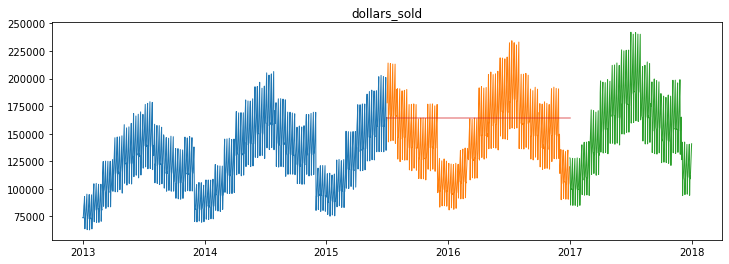

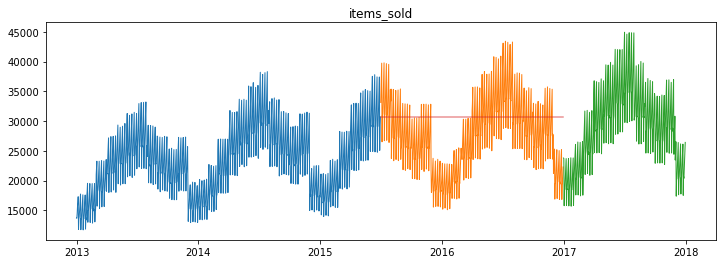

In [92]:
yhat_df = pd.DataFrame({'items_sold' : items, 'dollars_sold': dollars},
                      index=validate.index)

for col in train.columns:
    plot_and_eval(col)
plt.show()